In [1]:
from bs4 import BeautifulSoup
import pulp 
from collections import defaultdict, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import time
import pickle as pkl
import os
import sys
import re
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, ADASYN
import numpy as np
import SimpleITK as sitk
from joblib import Parallel, delayed
import nibabel as nib
from matplotlib import pyplot as plt
from scipy import ndimage


import json
import collections
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
from pyvis.network import Network

In [2]:
with open("cm_table.html", "r") as f:
    table = f.read()

soup = BeautifulSoup(table, "html.parser")

rows = soup.find_all(class_="powerTable")[1].tbody.find_all("tr")[3:523]

In [3]:
cols = defaultdict(list)
for row in rows:
    text_list = list(row.stripped_strings)
    if len(text_list) == 13:
        text_list.insert(7, 'na') # insert so list is standard size when that column was empty on the webpage
    cols["study"].append(text_list[2])
    cols["id"].append(text_list[3].replace("_", ""))
    cols["age"].append(float(text_list[8]))
    cols["gender"].append(text_list[10])
    cols["label"].append(text_list[11])

In [4]:
metadata = pd.DataFrame(cols)

In [5]:
del cols
del soup
del rows

In [6]:
def get_conn_matrices():
    file_names = os.listdir("ADHD200_CC200")

    cm_file_re = r"^\S+connectivity_matrix_file\.txt$"

    conn_matrices = OrderedDict()
    for file_name in file_names:
        if re.match(cm_file_re, file_name):
            id_ = "".join(file_name.split("_")[:-3])
        
            cm = np.empty((190,190))
            with open("ADHD200_CC200/{}".format(file_name)) as f:
                for idx, row in enumerate(f):
                    row = row.strip().split(" ")
                    row = list(map(np.float, row))
                    cm[idx, :] = row
            
            less_than_zero_mask = cm < 0 # get indices of values less than zero
            cm[less_than_zero_mask] = 0 # set values less than zero to zero
            
            conn_matrices[id_] = cm
    return conn_matrices

In [7]:
def get_regions(abbrev=True):

    regions_path = "ADHD200_CC200/KKI_1018959_region_names_abbrev_file.txt" if abbrev else "ADHD200_CC200/KKI_1018959_region_names_full_file.txt"
    regions = []
    with open(regions_path, "r") as f:
        regions = [region.strip().replace(" ", "_") for region in f]
    names = defaultdict(int)
    distinct_region_names = []
    for region in regions:
        distinct_region_names.append(region+"_"+str(names[region]))
        names[region] += 1
    return distinct_region_names

In [8]:
region_names = get_regions()

In [9]:
#region_names

In [10]:
print(len(region_names))
n_nodes = len(region_names)
lab_node = dict((i, region_names[i]) for i in range(n_nodes))

190


In [11]:
conn_matrices = get_conn_matrices()

In [12]:
#conn_matrices

In [76]:
mydata = conn_matrices['NYU0010080']

In [77]:
x, y, z = np.loadtxt("NYU_0010080_region_xyz_centers_file.txt", unpack=True)

In [78]:
pos3 = {i: (x[i] ,y[i] ,z[i] ) for i in range(n_nodes)}
pos2={i: (x[i] ,z[i]  ) for i in range(n_nodes)}
pos5={i: (x[i] ,y[i]  ) for i in range(n_nodes)}
pos4={i: (y[i] ,z[i]  ) for i in range(n_nodes)}

In [79]:
pos = pd.DataFrame(pos3, columns=['x', 'y', 'z'])

ed_ls = [(y, z) for y, z in zip(range(1, 10), range(1, 6))]


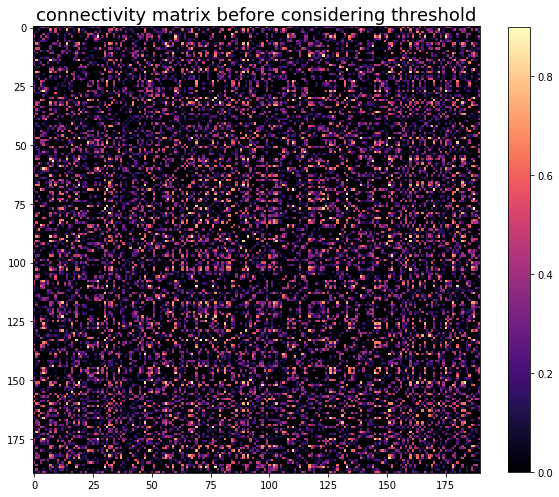

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(mydata, cmap='magma', interpolation='nearest')
plt.title("connectivity matrix before considering threshold", fontsize="18")
#plt.savefig("ADHD_connectivity_matrix.pdf")
plt.colorbar(shrink=.82)

plt.show() 


In [18]:
# if the measures have already been calculated and saved, just load them
load_measures = False
if load_measures:
    with open("conn_mat_measures_local.pkl", "rb") as f:
        measures = pkl.load(f)

In [19]:
def binarize(g, thresh):
    """
    Turn a weighted graph into an unweighted graph with the specified threshold.
    All edges less than the threshold become 0, while those above the threshold become 1.
    """
    return (g > thresh).astype(int)

In [20]:
# binarize each matrix
subjects = list(conn_matrices.keys())
binarized = OrderedDict()
for idx, subject in enumerate(subjects):
    cm = conn_matrices[subject]
    uw = binarize(cm, .5)
    binarized[subject] = uw

In [21]:
binarized['NYU0010080']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

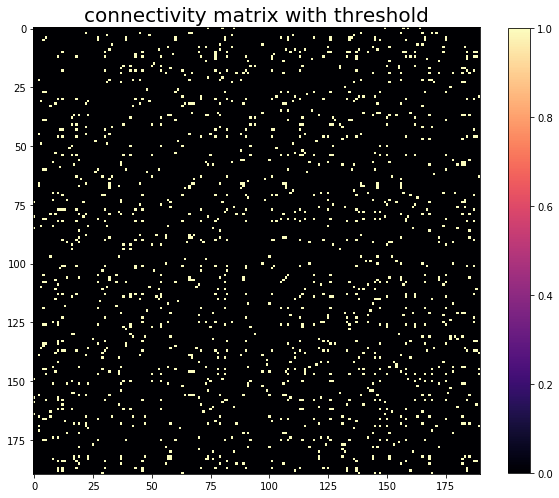

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(binarized['NYU1567356'], cmap='magma', interpolation='nearest')
plt.title("connectivity matrix with threshold", fontsize="20")
#plt.savefig("ADHD_connectivity_matrix_threshold.pdf")
plt.colorbar(shrink=.82)


plt.show()


In [54]:
def measure_graphs_local(binarized):
    """
    Calculate predetermined graph analytics for each graph and return then in a dict of lists.
    measures: degree centrality, closeness centrality, and nodal clustering coefficient
    
    These measures are calculated for each node in the network, so a list of the measures is created for each network
    """
    measures = {}
    
    print("calculating degree centralities")
    measures["degree_centrality"] = [nx.degree_centrality(nx.Graph(bu)) for bu in binarized.values()]
    
    print("calculating closeness centralities")
    measures["closeness_centrality"] = [nx.closeness_centrality(nx.Graph(bu)) for bu in binarized.values()]
    
    print("calculating clustering coefficients")
    measures["clustering_coefficient"] = [nx.clustering(nx.Graph(bu)) for bu in binarized.values()]
    
    return measures

In [30]:
measures = measure_graphs_local(binarized)

calculating degree centralities
calculating closeness centralities
calculating clustering coefficients


In [32]:
#measures

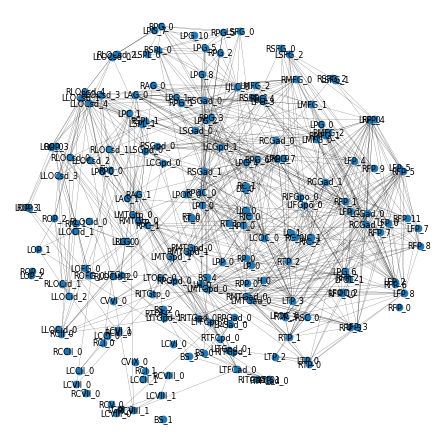

In [80]:
G = nx.Graph(binarized['NYU1567356'])
G.add_edges_from(ed_ls)

plt.figure(figsize=(6,6))
nx.draw(G,pos4, node_size=45,width=0.15, with_labels=True,font_size=8,labels=lab_node)

#plt.savefig("ADHD_orignial(coronal).pdf",transparent=True)
#m = len(G.nodes)
#print(m) 

In [99]:
G=Network(notebook=True)
G = nx.Graph(binarized['NYU1567356'])
G.add_edges_from(ed_ls)
g.show("example.html")

In [63]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('b.jpg')

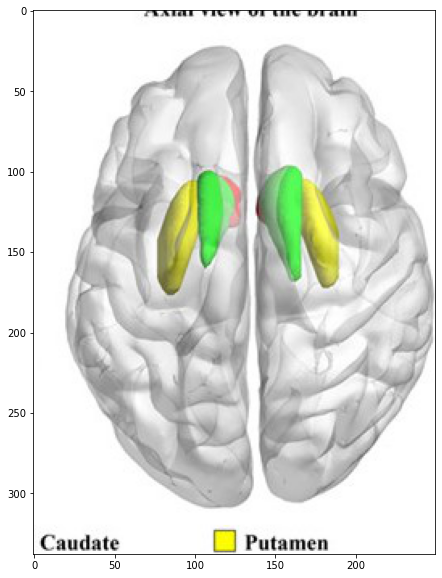

In [66]:
plt.figure(3,figsize=(10,10)) 
imgplot = plt.imshow(img)

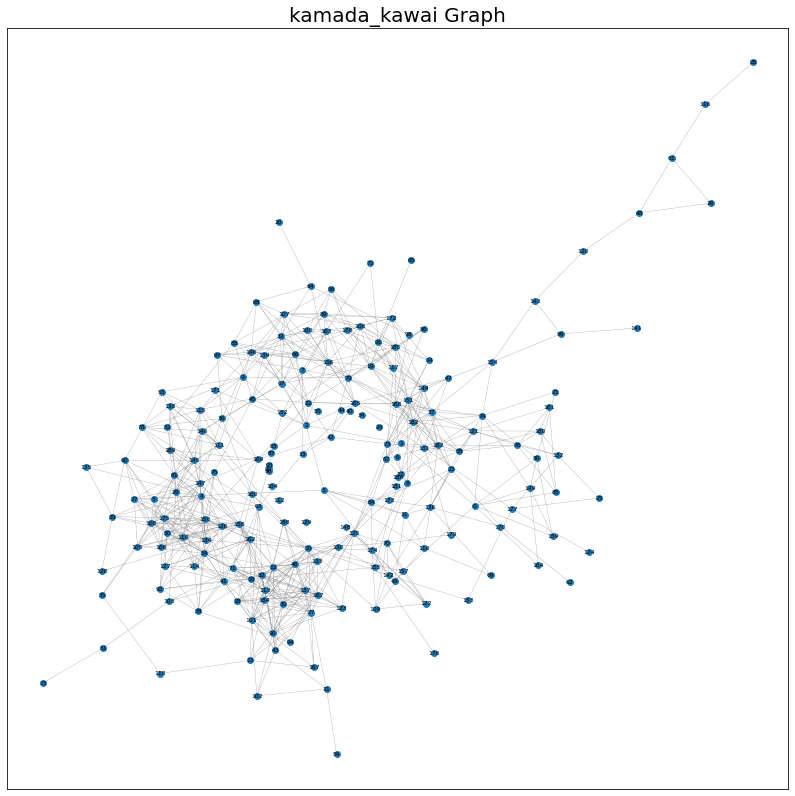

In [30]:
plt.figure(3,figsize=(14,14))
pos = nx.kamada_kawai_layout(G)

G.add_edges_from(ed_ls)
plt.title("kamada_kawai Graph", fontsize="20")
nx.draw_networkx(G, pos ,node_size=35,width=0.25, with_labels=True,font_size=6,edge_color='gray')
plt.savefig("ADHD_kamada_kawai.pdf")

## MDS

0.1778850555419922 seconds
0,1,6,11,13,15,21,24,28,34,38,39,40,44,48,54,55,64,70,71,76,79,83,87,88,91,93,95,96,99,104,105,110,111,112,125,129,146,148,155,165,169,170,173,177,181,186,

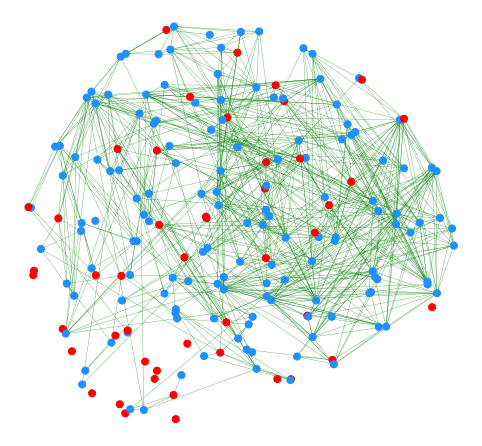

In [84]:
 # define the problem
prob = pulp.LpProblem("minimum_dominating_set", pulp.LpMinimize)

# define the variables
x = pulp.LpVariable.dicts("x", G.nodes(), cat=pulp.LpBinary)

# define the objective function
start_time = time.time()


for (v,u) in G.edges():
    
    prob += pulp.lpSum(x)
    
# define the constraints
for v in G.nodes():
       prob += x[v] + pulp.lpSum([x[u] for u in G.neighbors(v)]) >= 1
        
color_map = [] 
# solve
prob.solve()
end_time = time.time()
print("%s seconds" % (end_time - start_time))

# display solution
for v in G.nodes():
    if pulp.value(x[v]) > 0.99:
        
        color_map.append('red')
            
        print(v,end=',')
    else:
        color_map.append('dodgerblue') 
        
plt.figure(3,figsize=(6.5,6)) 
#pos = nx.kamada_kawai_layout(G)
#nx.draw(G, node_color=color_map, node_size=25,width=0.55, with_labels=True,font_size=8)
nx.draw(G, pos4,node_color=color_map, node_size=50,width=0.25, with_labels=False,font_size=8,edge_color='green',labels=lab_node)
plt.savefig("ADHD_MDS(segital).pdf",transparent=True)
plt.show()



In [115]:
N = 0
for v in prob.variables():
    if v.varValue == 1:
        #print(v.name, "=", v.varValue)
        N = N+1
print(N)

47
